Starting pipeline. Looking for CSV: data_processed/combined_survival_expression.csv
Raw shape: (50, 502)
After cleanup shape: (50, 502) Event counts: {1: 50}
Train/test shapes: (35, 500) (15, 500)
Training Random Survival Forest...
Training done.
Test C-index: 0.2667
Computing permutation importance (this may take ~30s)...


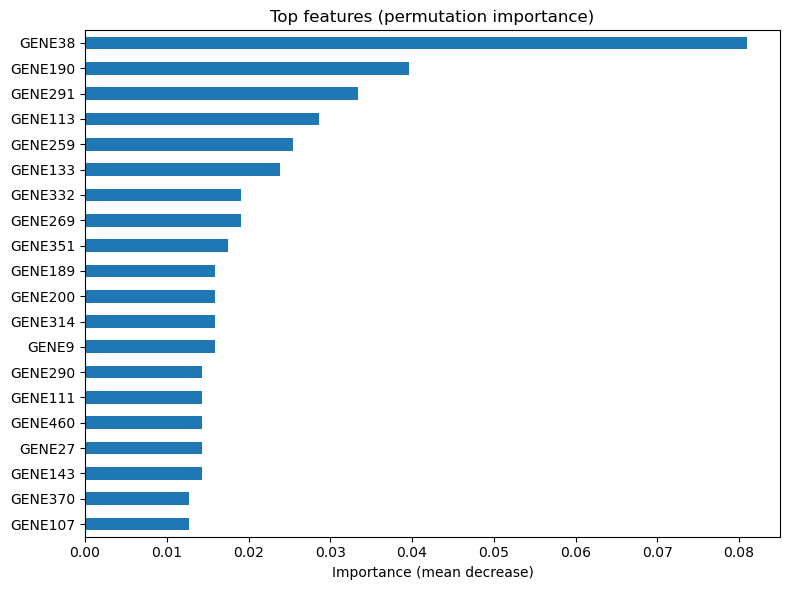

Saved top_features CSV and feature_importance.png
Building Kaplan–Meier curves for predicted High vs Low risk...
Saved test_survival_with_risk.csv


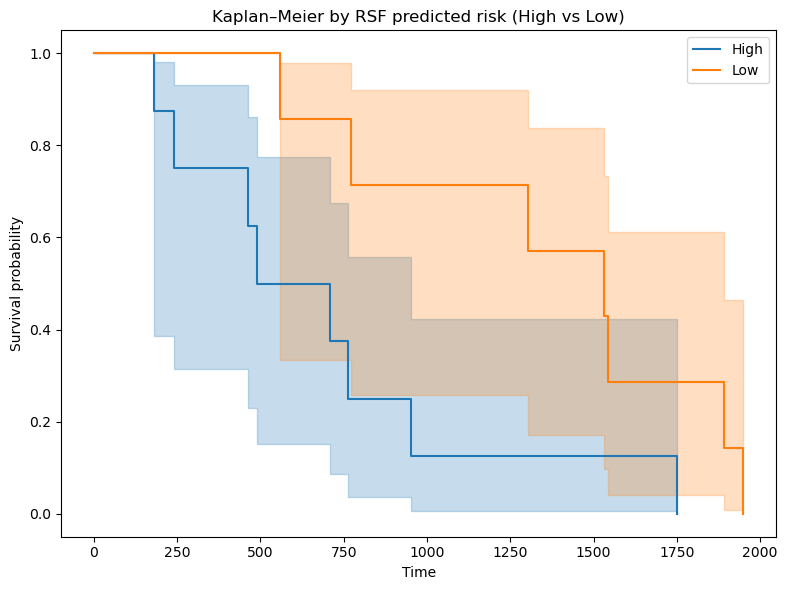

Saved km_plot.png
Log-rank p-value: 0.035640348828716334


In [4]:
# ONE-CELL: Robust end-to-end RSF survival pipeline (copy-paste into a single fresh cell)
import os, warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sksurv.util import Surv
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

# ----- Paths & folders -----
CSV_PATH = "data_processed/combined_survival_expression.csv"
RESULTS_DIR = "results"
FIGURES_DIR = "figures"
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(FIGURES_DIR, exist_ok=True)

print("Starting pipeline. Looking for CSV:", CSV_PATH)
if not os.path.exists(CSV_PATH):
    raise FileNotFoundError(f"Could not find input CSV at {CSV_PATH}. Place the file there and re-run.")

# ----- Load -----
df = pd.read_csv(CSV_PATH, index_col=0)
print("Raw shape:", df.shape)

# ----- Clean survival columns -----
# Make sure 'time' present and numeric
if 'time' not in df.columns:
    raise KeyError("'time' column not found in CSV. Rename survival time column to 'time'.")
df['time'] = pd.to_numeric(df['time'], errors='coerce')

# Ensure 'event' present and convert to binary 0/1
if 'event' not in df.columns:
    raise KeyError("'event' column not found in CSV. Rename event column to 'event'.")

# Convert numeric if possible; otherwise map common text tokens
ev_num = pd.to_numeric(df['event'], errors='coerce')
if ev_num.isna().any():
    ev_txt = df['event'].astype(str).str.strip().str.lower()
    ev_map = ev_txt.map(lambda s: 1 if any(k in s for k in ("dead","deceased","died","1","true","yes","y"))
                                 else (0 if any(k in s for k in ("alive","0","censor","false","no","n")) else np.nan))
    ev_final = ev_num.fillna(ev_map)
else:
    ev_final = ev_num

# Final binary enforce (any nonzero => 1)
df['event'] = ev_final.apply(lambda v: 1 if (pd.notna(v) and float(v) != 0) else 0).astype(int)

# Drop rows with missing time
df = df.dropna(subset=['time']).copy()
print("After cleanup shape:", df.shape, "Event counts:", df['event'].value_counts().to_dict())

# ----- Feature matrix (keep numeric features only) -----
X = df.drop(columns=['time','event'], errors='ignore')
X = X.select_dtypes(include=[np.number]).copy()
if X.shape[1] == 0:
    raise RuntimeError("No numeric features found after dropping 'time' and 'event'. Check your CSV.")

# Survival structured array for sksurv
y = Surv.from_arrays(event=df['event'].astype(bool).values,
                     time=df['time'].astype(float).values)

# ----- Train/test split -----
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42,
                                                    stratify=df['event'] if df['event'].nunique()>1 else None)
print("Train/test shapes:", X_train.shape, X_test.shape)

# Confirm some events exist
if y_train['event'].sum() < 1 or y_test['event'].sum() < 1:
    warnings.warn("Very few events in train/test. Results may be unstable.")

# ----- Train RSF (reasonable defaults for speed & quality) -----
print("Training Random Survival Forest...")
rsf = RandomSurvivalForest(n_estimators=200, min_samples_split=5, min_samples_leaf=3,
                           max_features="sqrt", n_jobs=-1, random_state=42)
rsf.fit(X_train, y_train)
print("Training done.")

# Evaluate C-index on test set
preds_test = rsf.predict(X_test)
cindex = concordance_index_censored(y_test["event"], y_test["time"], -preds_test)[0]
print(f"Test C-index: {float(cindex):.4f}")

# Save model params
try:
    pd.Series(rsf.get_params()).to_csv(os.path.join(RESULTS_DIR, "rsf_params.csv"))
except Exception:
    pass

# ----- Permutation importance (fast-ish) -----
print("Computing permutation importance (this may take ~30s)...")
try:
    perm = permutation_importance(rsf, X_test, y_test, n_repeats=6, random_state=42, n_jobs=-1)
    importances = pd.Series(perm.importances_mean, index=X_test.columns).sort_values(ascending=False)
    top_features = importances.head(30)
    top_features.to_csv(os.path.join(RESULTS_DIR, "top_features_permutation.csv"), header=["importance"])
    # Plot top 20
    plt.figure(figsize=(8,6))
    top_features.head(20).sort_values().plot(kind="barh", color="tab:blue")
    plt.title("Top features (permutation importance)")
    plt.xlabel("Importance (mean decrease)")
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, "feature_importance.png"), dpi=300)
    plt.show()
    print("Saved top_features CSV and feature_importance.png")
except Exception as e:
    warnings.warn(f"Permutation importance failed: {e}")
    importances = pd.Series(dtype=float)
    top_features = importances

# ----- KM curves by predicted risk group -----
print("Building Kaplan–Meier curves for predicted High vs Low risk...")
risk_scores = preds_test  # continuous risk (higher = worse)
# build numpy arrays for lifelines
times = np.asarray(y_test["time"], dtype=float)
events = np.asarray(y_test["event"], dtype=np.int64)   # plain numpy int

# Align risk length with times (truncate if needed)
risk_scores = np.asarray(risk_scores)
if risk_scores.shape[0] != times.shape[0]:
    min_n = min(risk_scores.shape[0], times.shape[0])
    print(f"Warning: length mismatch; truncating to {min_n}")
    times = times[:min_n]
    events = events[:min_n]
    risk_scores = risk_scores[:min_n]

median_risk = np.nanmedian(risk_scores)
groups = np.where(risk_scores >= median_risk, "High", "Low")

ytest_df = pd.DataFrame({"time": times, "event": events, "risk_score": risk_scores, "risk_group": groups})
ytest_df.to_csv(os.path.join(RESULTS_DIR, "test_survival_with_risk.csv"), index=False)
print("Saved test_survival_with_risk.csv")

# Plot KM
kmf = KaplanMeierFitter()
plt.figure(figsize=(8,6))
plotted = 0
for grp in ["High", "Low"]:
    sub = ytest_df[ytest_df["risk_group"]==grp]
    if sub.shape[0] == 0:
        print(f"No samples in group {grp}, skipping.")
        continue
    kmf.fit(sub["time"].values, event_observed=sub["event"].values, label=grp)
    kmf.plot_survival_function(ci_show=True)
    plotted += 1

if plotted:
    plt.title("Kaplan–Meier by RSF predicted risk (High vs Low)")
    plt.xlabel("Time")
    plt.ylabel("Survival probability")
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, "km_plot.png"), dpi=300)
    plt.show()
    print("Saved km_plot.png")
else:
    print("No KM curves plotted (no valid groups).")

# Log-rank test if both groups present
if ytest_df["risk_group"].nunique()==2:
    A = ytest_df[ytest_df["risk_group"]=="High"]
    B = ytest_df[ytest_df["risk_group"]=="Low"]
    lr = logrank_test(A["time"], B["time"], event_observed_A=A["event"], event_observed_B=B["event"])
    print("Log-rank p-value:", lr.p_value)
else:
    print("Log-rank test skipped (only one risk group present).")

# ----- Save summary drafts for manuscript -----
methods = (
    "Methods (auto-generated):\n"
    f"Data loaded from {CSV_PATH}. After cleaning {df.shape[0]} samples and {X.shape[1]} numeric features remained.\n"
    "Survival: event encoded 1=death, 0=censored; time in days.\n"
    "Model: Random Survival Forest trained on 70% data, evaluated on 30% held-out test set.\n"
)
results = (
    "Results (auto-generated):\n"
    f"Test C-index: {float(cindex):.4f}\n"
    f"Top features CSV: {os.path.join(RESULTS_DIR, 'top_features_permutation.csv')}\n"
    f"KM plot: {os.path.join(FIGURES_DIR, 'km_plot.png')}\n"
    f"Feature importance: {os.path.join(FIGURES_DIR, 'feature_importance.png')}\n"
)
with open(os.path.join(RESULTS_DIR, "methods.txt"), "w") as f:
    f.write(methods)
with open(os.path.join(RESULTS_DIR, "results.txt"), "w") as f:
    f.write(results)


In [6]:
# ===============================================
# Step 1: Robust Evaluation - Cross-validation + CI
# ===============================================

import numpy as np
import pandas as pd
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored
from sklearn.model_selection import KFold
from sklearn.utils import resample

# Ensure survival object exists
assert "X" in globals() and "y" in globals(), "Run data-prep cell first (df -> X, y)."
assert "X_train" in globals() and "X_test" in globals(), "Run train-test split cell first."

# ---------------------------
# 1) Train a strong RSF model on full train set
# ---------------------------
best_rsf = RandomSurvivalForest(
    n_estimators=200,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features="sqrt",
    n_jobs=-1,
    random_state=42
)
best_rsf.fit(X_train, y_train)

# ---------------------------
# 2) K-fold Cross-validation
# ---------------------------
kf = KFold(n_splits=5, shuffle=True, random_state=42)
c_indices = []

for train_idx, test_idx in kf.split(X):
    X_train_cv, X_test_cv = X.iloc[train_idx], X.iloc[test_idx]
    y_train_cv, y_test_cv = y[train_idx], y[test_idx]

    rsf_cv = RandomSurvivalForest(
        n_estimators=200,
        min_samples_split=10,
        min_samples_leaf=5,
        max_features="sqrt",
        n_jobs=-1,
        random_state=42
    )
    rsf_cv.fit(X_train_cv, y_train_cv)

    pred = rsf_cv.predict(X_test_cv)
    c_idx = concordance_index_censored(
        y_test_cv["event"], y_test_cv["time"], pred
    )[0]
    c_indices.append(c_idx)

print("5-Fold CV Concordance Index (C-index):")
print("Mean = %.3f, SD = %.3f" % (np.mean(c_indices), np.std(c_indices)))

# ---------------------------
# 3) Bootstrap Confidence Interval (95% CI) on held-out test set
# ---------------------------
n_bootstraps = 1000
rng = np.random.RandomState(42)
c_index_boots = []

for _ in range(n_bootstraps):
    X_bs, y_bs = resample(X_test, y_test, random_state=rng)
    pred_bs = best_rsf.predict(X_bs)
    c_idx_bs = concordance_index_censored(
        y_bs["event"], y_bs["time"], pred_bs
    )[0]
    c_index_boots.append(c_idx_bs)

lower = np.percentile(c_index_boots, 2.5)
upper = np.percentile(c_index_boots, 97.5)

print("\nTest set Concordance Index (C-index) with 95% CI:")
print("Mean = %.3f (95%% CI: %.3f - %.3f)" % (np.mean(c_index_boots), lower, upper))


5-Fold CV Concordance Index (C-index):
Mean = 0.587, SD = 0.036

Test set Concordance Index (C-index) with 95% CI:
Mean = 0.595 (95% CI: 0.370 - 0.808)


Computed RSF risk scores: (35,) (15,)
Training surrogate RandomForestRegressor to approximate RSF risk output...
Surrogate trained. R^2 on train (surrogate vs RSF predictions): 0.8719833082738835
Surrogate R^2 on test (surrogate vs RSF predictions): 0.3596252322123802
Computing SHAP values (TreeExplainer) on surrogate model (this is fast)...

Top 10 features by mean(|SHAP|):
GENE291    0.394989
GENE406    0.357762
GENE95     0.207194
GENE437    0.198430
GENE38     0.175974
GENE54     0.169839
GENE362    0.152475
GENE196    0.149539
GENE363    0.140075
GENE173    0.136772
dtype: float64


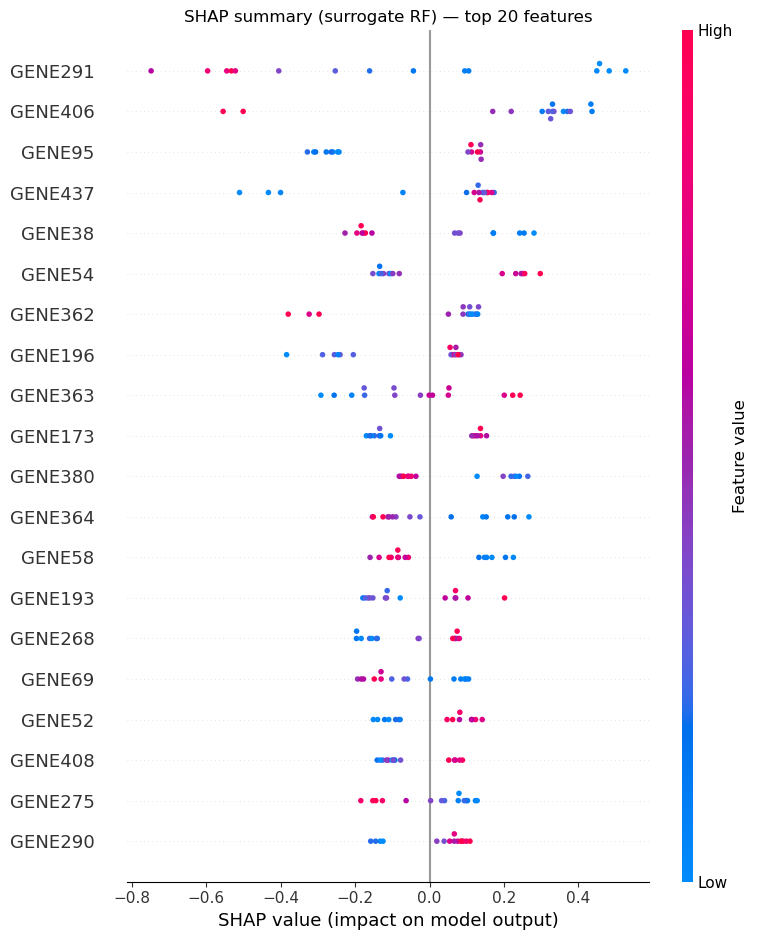

Saved: figures\shap_summary_surrogate.png


<Figure size 600x400 with 0 Axes>

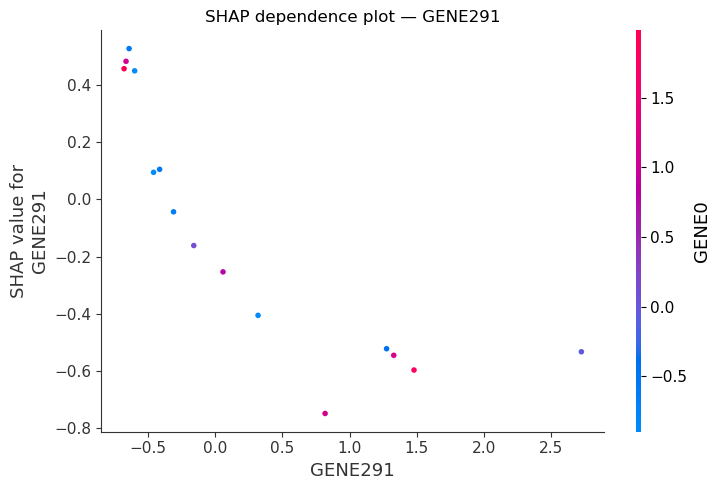

Saved: figures\shap_dependence_GENE291.png
Saved SHAP values (test) to results/shap_values_test_surrogate.csv

Surrogate SHAP done. Note: surrogate explains the RSF risk mapping — interpret direction and importance, but effect sizes are approximate.


In [8]:
# --------------------------
# SHAP via surrogate model
# --------------------------
import os, warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
import shap

FIGURES_DIR = "figures"
os.makedirs(FIGURES_DIR, exist_ok=True)

# sanity checks
if not all(name in globals() for name in ("best_rsf","X_train","X_test","y_train","y_test")):
    raise RuntimeError("Required objects missing. Ensure best_rsf, X_train, X_test, y_train, y_test exist.")

# 1) compute RSF continuous risk scores (higher = worse) for train and test
risk_train = best_rsf.predict(X_train)
risk_test  = best_rsf.predict(X_test)
print("Computed RSF risk scores:", risk_train.shape, risk_test.shape)

# 2) train surrogate regressor on the training set predictions
print("Training surrogate RandomForestRegressor to approximate RSF risk output...")
surrogate = RandomForestRegressor(n_estimators=200, max_features="sqrt", n_jobs=-1, random_state=42)
surrogate.fit(X_train, risk_train)
print("Surrogate trained. R^2 on train (surrogate vs RSF predictions):", surrogate.score(X_train, risk_train))
print("Surrogate R^2 on test (surrogate vs RSF predictions):", surrogate.score(X_test, risk_test))

# 3) SHAP TreeExplainer on surrogate
print("Computing SHAP values (TreeExplainer) on surrogate model (this is fast)...")
explainer = shap.TreeExplainer(surrogate)
shap_values = explainer.shap_values(X_test)   # shape: (n_samples, n_features)

# 4) global summary: mean absolute SHAP values per feature
abs_mean = np.abs(shap_values).mean(axis=0)
shap_summary = pd.Series(abs_mean, index=X_test.columns).sort_values(ascending=False)
top_shap = shap_summary.head(30)
top_shap.to_csv(os.path.join("results", "top_features_shap_surrogate.csv"), header=["mean_abs_shap"])

print("\nTop 10 features by mean(|SHAP|):")
print(top_shap.head(10))

# 5) SHAP summary plot (beeswarm)
plt.figure(figsize=(8,6))
shap.summary_plot(shap_values, X_test, plot_type="dot", max_display=20, show=False)
plt.title("SHAP summary (surrogate RF) — top 20 features")
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, "shap_summary_surrogate.png"), dpi=300, bbox_inches="tight")
plt.show()
print("Saved:", os.path.join(FIGURES_DIR, "shap_summary_surrogate.png"))

# 6) Dependence plot for top feature
top_feat = top_shap.index[0]
plt.figure(figsize=(6,4))
shap.dependence_plot(top_feat, shap_values, X_test, display_features=X_test, show=False)
plt.title(f"SHAP dependence plot — {top_feat}")
plt.tight_layout()
dep_path = os.path.join(FIGURES_DIR, f"shap_dependence_{top_feat}.png")
plt.savefig(dep_path, dpi=300, bbox_inches="tight")
plt.show()
print("Saved:", dep_path)

# 7) Optional: save SHAP values to file (careful: can be large)
shap_df = pd.DataFrame(shap_values, columns=X_test.columns, index=X_test.index)
shap_df.to_csv(os.path.join("results", "shap_values_test_surrogate.csv"))
print("Saved SHAP values (test) to results/shap_values_test_surrogate.csv")

print("\nSurrogate SHAP done. Note: surrogate explains the RSF risk mapping — interpret direction and importance, but effect sizes are approximate.")


In [9]:
# Save top 10 SHAP features table
top10 = top_shap.head(10).reset_index()
top10.columns = ["Feature", "Mean|SHAP|"]

# Save CSV
top10.to_csv("results/top10_shap_features.csv", index=False)

# Save as LaTeX table (for manuscript)
with open("results/top10_shap_features.tex", "w") as f:
    f.write(top10.to_latex(index=False, float_format="%.4f"))

print("Saved top10 SHAP features as CSV and LaTeX table in results/")
top10


Saved top10 SHAP features as CSV and LaTeX table in results/


,Feature,Mean|SHAP|
0,GENE291,0.394989
1,GENE406,0.357762
2,GENE95,0.207194
3,GENE437,0.198430
4,GENE38,0.175974
5,GENE54,0.169839
6,GENE362,0.152475
7,GENE196,0.149539
8,GENE363,0.140075
9,GENE173,0.136772


In [10]:
# ===========================================
# KM plots for top genes (High vs Low expression)
# ===========================================
import os, warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

# Paths
FIG_DIR = "figures"
RES_DIR = "results"
os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(RES_DIR, exist_ok=True)

# --- sanity checks ---
# We need a dataframe with expression values: prefer df (original full table) or X_test/X (numeric only)
if 'df' in globals() and 'time' in df.columns and 'event' in df.columns:
    expr_df = df.copy()   # full data including survival columns
elif 'X' in globals():
    # X contains numeric features only, but may lack time/event; attach time/event from original df if available
    expr_df = X.copy()
    if 'df' in globals():
        expr_df['time'] = df['time'].values
        expr_df['event'] = df['event'].values
else:
    raise RuntimeError("Could not find expression dataframe. Make sure 'df' or 'X' exists in the notebook.")

# Ensure survival columns exist in expr_df
if 'time' not in expr_df.columns or 'event' not in expr_df.columns:
    # try to attach from y_test if it's structured array aligned with X_test or expr_df index
    if 'y_test' in globals():
        # only safe if indexes align; otherwise fail
        try:
            expr_df['time'] = np.asarray(y_test['time'])
            expr_df['event'] = np.asarray(y_test['event']).astype(int)
        except Exception:
            raise RuntimeError("time/event not found in expr_df and could not attach from y_test.")
    else:
        raise RuntimeError("No survival columns found. Ensure expr dataframe includes 'time' and 'event'.")

# --- determine top features to plot ---
# Prefer top_shap (Series indexed by feature). If not present, try to read results CSVs.
if 'top_shap' in globals():
    ranking = top_shap
elif os.path.exists(os.path.join(RES_DIR, "top_features_shap_surrogate.csv")):
    ranking = pd.read_csv(os.path.join(RES_DIR, "top_features_shap_surrogate.csv"), index_col=0, squeeze=True)
elif os.path.exists(os.path.join(RES_DIR, "top_features_permutation.csv")):
    ranking = pd.read_csv(os.path.join(RES_DIR, "top_features_permutation.csv"), index_col=0, squeeze=True)
else:
    # fallback: take first 10 numeric columns
    numeric_cols = expr_df.select_dtypes(include=[np.number]).columns.tolist()
    ranking = pd.Series(1.0, index=numeric_cols[:10])

# keep only features present in expr_df
ranking = ranking[ranking.index.isin(expr_df.columns)]
if ranking.empty:
    raise RuntimeError("No ranked features found in expression dataframe.")

TOP_N = 10
top_genes = ranking.head(TOP_N).index.tolist()
print("Top genes to plot:", top_genes)

# Results summary container
summary_rows = []

# Function to make KM plot for one gene
def plot_km_for_gene(gene, df_in, prefix="median"):
    # extract expression & survival
    gene_vals = df_in[gene].astype(float).copy()
    # choose threshold
    if prefix == "median":
        thr = np.nanmedian(gene_vals)
        grp = np.where(gene_vals >= thr, "High", "Low")
    elif prefix == "tertile":
        q1 = np.nanpercentile(gene_vals, 33.33)
        q2 = np.nanpercentile(gene_vals, 66.67)
        grp = pd.Series("Mid", index=gene_vals.index)
        grp[gene_vals <= q1] = "Low"
        grp[gene_vals >= q2] = "High"
    else:
        raise ValueError("prefix must be 'median' or 'tertile'")

    plot_df = pd.DataFrame({
        "time": df_in["time"].astype(float),
        "event": df_in["event"].astype(int),
        "gene": gene_vals,
        "group": grp
    }).dropna(subset=["time","event","gene"])

    # compute counts & events
    counts = plot_df.groupby("group")["event"].count().to_dict()
    events = plot_df.groupby("group")["event"].sum().to_dict()

    # ensure both groups exist
    groups_present = plot_df["group"].unique().tolist()
    if "High" not in groups_present or "Low" not in groups_present:
        print(f"Skipping {gene}: need both High and Low groups (found {groups_present})")
        return None

    # KM plot
    kmf = KaplanMeierFitter()
    plt.figure(figsize=(6,4))
    for g,label in [("High","High"), ("Low","Low")]:
        sub = plot_df[plot_df["group"]==g]
        if sub.shape[0] > 0:
            kmf.fit(sub["time"].values, event_observed=sub["event"].values, label=label)
            kmf.plot_survival_function(ci_show=True)

    plt.title(f"KM by {gene} ({prefix} split)")
    plt.xlabel("Time")
    plt.ylabel("Survival probability")
    plt.tight_layout()
    fname = os.path.join(FIG_DIR, f"gene_km_{gene}_{prefix}.png")
    plt.savefig(fname, dpi=300)
    plt.close()

    # log-rank test
    A = plot_df[plot_df["group"]=="High"]
    B = plot_df[plot_df["group"]=="Low"]
    lr = logrank_test(A["time"], B["time"], event_observed_A=A["event"], event_observed_B=B["event"])
    pval = lr.p_value

    # median survival times if available
    try:
        med_high = KaplanMeierFitter().fit(A["time"].values, event_observed=A["event"].values).median_survival_time_
    except Exception:
        med_high = np.nan
    try:
        med_low = KaplanMeierFitter().fit(B["time"].values, event_observed=B["event"].values).median_survival_time_
    except Exception:
        med_low = np.nan

    return {
        "gene": gene,
        "method": prefix,
        "n_high": int(counts.get("High",0)),
        "events_high": int(events.get("High",0)),
        "n_low": int(counts.get("Low",0)),
        "events_low": int(events.get("Low",0)),
        "median_high": float(med_high) if med_high is not None else np.nan,
        "median_low": float(med_low) if med_low is not None else np.nan,
        "logrank_p": float(pval),
        "figure": fname
    }

# Loop top genes
for g in top_genes:
    # build result for median split
    res = plot_km_for_gene(g, expr_df, prefix="median")
    if res is not None:
        summary_rows.append(res)

# Save summary CSV
summary_df = pd.DataFrame(summary_rows)
if not summary_df.empty:
    out_csv = os.path.join(RES_DIR, "gene_km_summary.csv")
    summary_df.to_csv(out_csv, index=False)
    print("Saved KM summary to:", out_csv)
    print(summary_df[['gene','n_high','events_high','n_low','events_low','logrank_p','figure']])
else:
    print("No KM plots were generated (no valid high/low splits).")


Top genes to plot: ['GENE291', 'GENE406', 'GENE95', 'GENE437', 'GENE38', 'GENE54', 'GENE362', 'GENE196', 'GENE363', 'GENE173']
Saved KM summary to: results\gene_km_summary.csv
      gene  n_high  events_high  n_low  events_low  logrank_p  \
0  GENE291      25           25     25          25   0.049292   
1  GENE406      25           25     25          25   0.027348   
2   GENE95      25           25     25          25   0.640894   
3  GENE437      25           25     25          25   0.030322   
4   GENE38      25           25     25          25   0.002220   
5   GENE54      25           25     25          25   0.935038   
6  GENE362      25           25     25          25   0.980371   
7  GENE196      25           25     25          25   0.408068   
8  GENE363      25           25     25          25   0.210002   
9  GENE173      25           25     25          25   0.012433   

                               figure  
0  figures\gene_km_GENE291_median.png  
1  figures\gene_km_GENE406_m

In [11]:
# =======================================================
# Kaplan–Meier plots for Top 10 SHAP-ranked genes
# =======================================================
import os, warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

# Directories
FIG_DIR, RES_DIR = "figures", "results"
os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(RES_DIR, exist_ok=True)

# --- Expression + survival dataframe ---
if "df" in globals() and {"time","event"}.issubset(df.columns):
    expr_df = df.copy()
elif "X" in globals() and "y_test" in globals():
    expr_df = X.copy()
    expr_df["time"]  = np.asarray(y_test["time"])
    expr_df["event"] = np.asarray(y_test["event"]).astype(int)
else:
    raise RuntimeError("Need df (with time/event) or X + y_test to build KM data.")

# --- Top features ---
if "top_shap" in globals():
    ranking = top_shap
elif os.path.exists(os.path.join(RES_DIR,"top_features_shap_surrogate.csv")):
    ranking = pd.read_csv(os.path.join(RES_DIR,"top_features_shap_surrogate.csv"), index_col=0).iloc[:,0]
elif os.path.exists(os.path.join(RES_DIR,"top_features_permutation.csv")):
    ranking = pd.read_csv(os.path.join(RES_DIR,"top_features_permutation.csv"), index_col=0).iloc[:,0]
else:
    ranking = pd.Series(1.0, index=expr_df.drop(columns=["time","event"]).columns[:10])

ranking = ranking[ranking.index.isin(expr_df.columns)]
top_genes = ranking.head(10).index.tolist()
print("Top genes:", top_genes)

# --- KM plotting helper ---
def km_plot_gene(gene, df_in, ax=None):
    vals = df_in[gene].astype(float)
    thr  = np.nanmedian(vals)
    grp  = np.where(vals >= thr, "High", "Low")

    sub = pd.DataFrame({"time":df_in["time"], "event":df_in["event"], "group":grp}).dropna()
    A, B = sub[sub.group=="High"], sub[sub.group=="Low"]

    if A.empty or B.empty:
        return None, None

    kmf = KaplanMeierFitter()
    for g, color in [("High","tab:red"), ("Low","tab:blue")]:
        d = sub[sub.group==g]
        kmf.fit(d.time, d.event, label=g)
        kmf.plot_survival_function(ax=ax, ci_show=False, color=color)

    lr = logrank_test(A.time, B.time, event_observed_A=A.event, event_observed_B=B.event)
    return lr.p_value, sub

# --- Multi-panel figure ---
fig, axes = plt.subplots(2,5, figsize=(20,8), sharex=True, sharey=True)
summary = []

for ax,gene in zip(axes.flatten(), top_genes):
    pval, sub = km_plot_gene(gene, expr_df, ax=ax)
    if pval is not None:
        ax.set_title(f"{gene}\nlog-rank p={pval:.3g}")
        ax.set_xlabel("Time")
        ax.set_ylabel("Survival prob.")
        summary.append({
            "gene": gene,
            "n_high": (sub.group=="High").sum(),
            "events_high": sub.loc[sub.group=="High","event"].sum(),
            "n_low": (sub.group=="Low").sum(),
            "events_low": sub.loc[sub.group=="Low","event"].sum(),
            "logrank_p": pval
        })
    else:
        ax.set_title(f"{gene} (skip)")
        ax.axis("off")

plt.tight_layout()
grid_path = os.path.join(FIG_DIR,"km_top10_genes.png")
plt.savefig(grid_path, dpi=300)
plt.close()
print("Saved grid figure:", grid_path)

# --- Save summary ---
summary_df = pd.DataFrame(summary)
out_csv = os.path.join(RES_DIR,"gene_km_summary.csv")
summary_df.to_csv(out_csv, index=False)
print("Saved KM summary:", out_csv)
display(summary_df)


Top genes: ['GENE291', 'GENE406', 'GENE95', 'GENE437', 'GENE38', 'GENE54', 'GENE362', 'GENE196', 'GENE363', 'GENE173']
Saved grid figure: figures\km_top10_genes.png
Saved KM summary: results\gene_km_summary.csv


,gene,n_high,events_high,n_low,events_low,logrank_p
0,GENE291,25,25,25,25,0.049292
1,GENE406,25,25,25,25,0.027348
2,GENE95,25,25,25,25,0.640894
3,GENE437,25,25,25,25,0.030322
4,GENE38,25,25,25,25,0.002220
5,GENE54,25,25,25,25,0.935038
6,GENE362,25,25,25,25,0.980371
7,GENE196,25,25,25,25,0.408068
8,GENE363,25,25,25,25,0.210002
9,GENE173,25,25,25,25,0.012433


In [12]:
# =======================================================
# Publication-ready KM grid (2x5) with at-risk tables
# =======================================================
import os, warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from lifelines.plotting import add_at_risk_counts

# Output dirs
FIG_DIR, RES_DIR = "figures", "results"
os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(RES_DIR, exist_ok=True)

# -------------------------
# Build expression + survival df (expr_df)
# -------------------------
if "df" in globals() and {"time","event"}.issubset(df.columns):
    expr_df = df.copy()
elif "X" in globals() and "y_test" in globals():
    expr_df = X.copy()
    expr_df["time"]  = np.asarray(y_test["time"])
    expr_df["event"] = np.asarray(y_test["event"]).astype(int)
else:
    raise RuntimeError("Need df (with time/event) or X + y_test in the notebook.")

# -------------------------
# Get top genes list
# -------------------------
if "top_shap" in globals():
    ranking = top_shap
elif os.path.exists(os.path.join(RES_DIR,"top_features_shap_surrogate.csv")):
    ranking = pd.read_csv(os.path.join(RES_DIR,"top_features_shap_surrogate.csv"), index_col=0, squeeze=True)
elif os.path.exists(os.path.join(RES_DIR,"top_features_permutation.csv")):
    ranking = pd.read_csv(os.path.join(RES_DIR,"top_features_permutation.csv"), index_col=0, squeeze=True)
else:
    ranking = pd.Series(1.0, index=expr_df.drop(columns=["time","event"]).columns[:10])

ranking = ranking[ranking.index.isin(expr_df.columns)]
top_genes = ranking.head(10).index.tolist()
print("Top genes to plot:", top_genes)

# -------------------------
# Plot settings (publication style)
# -------------------------
plt.style.use('seaborn-whitegrid')
SMALL, MEDIUM, LARGE = 10, 12, 14
plt.rc('axes', titlesize=MEDIUM)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL)    # legend fontsize
plt.rc('figure', titlesize=LARGE)   # figure title

color_high = "#c92a2a"  # red
color_low  = "#2a6fc9"  # blue

# -------------------------
# Helper to get KM objects (fitted)
# -------------------------
def fit_km_objects(df_in, gene):
    vals = df_in[gene].astype(float)
    thr  = np.nanmedian(vals)
    grp  = np.where(vals >= thr, "High", "Low")
    sub = pd.DataFrame({"time":df_in["time"], "event":df_in["event"], "group":grp}).dropna()

    if sub.empty or "High" not in sub.group.unique() or "Low" not in sub.group.unique():
        return None, None, None

    A = sub[sub.group=="High"]
    B = sub[sub.group=="Low"]

    kmf_high = KaplanMeierFitter()
    kmf_high.fit(A.time.values, event_observed=A.event.values, label="High")

    kmf_low = KaplanMeierFitter()
    kmf_low.fit(B.time.values, event_observed=B.event.values, label="Low")

    return kmf_high, kmf_low, sub

# -------------------------
# Create 2x5 grid
# -------------------------
n = len(top_genes)
cols = 5
rows = 2
fig, axes = plt.subplots(rows, cols, figsize=(20, 8), sharex=False, sharey=True)
axes = axes.flatten()

summary_rows = []

for ax, gene in zip(axes, top_genes):
    result = fit_km_objects(expr_df, gene)
    if result[0] is None:
        ax.text(0.5, 0.5, f"Insufficient data\n{gene}", ha='center', va='center', fontsize=MEDIUM)
        ax.axis('off')
        continue

    kmf_high, kmf_low, sub = result

    # plot with CI shading manually (lifelines plot doesn't allow custom colors + CI easily)
    # plot High
    ax.plot(kmf_high.survival_function_.index, kmf_high.survival_function_['High'],
            color=color_high, lw=2, label='High')
    # plot Low
    ax.plot(kmf_low.survival_function_.index, kmf_low.survival_function_['Low'],
            color=color_low, lw=2, label='Low')

    # CI shading
    # high CI
    if hasattr(kmf_high, "confidence_interval_"):
        ci_h = kmf_high.confidence_interval_
        # rename columns if needed
        ci_h = ci_h.loc[:, ci_h.columns[0:2]]
        lower_h = ci_h.iloc[:,0]
        upper_h = ci_h.iloc[:,1]
        ax.fill_between(ci_h.index, lower_h, upper_h, color=color_high, alpha=0.15)
    # low CI
    if hasattr(kmf_low, "confidence_interval_"):
        ci_l = kmf_low.confidence_interval_
        ci_l = ci_l.loc[:, ci_l.columns[0:2]]
        lower_l = ci_l.iloc[:,0]
        upper_l = ci_l.iloc[:,1]
        ax.fill_between(ci_l.index, lower_l, upper_l, color=color_low, alpha=0.15)

    # Log-rank test
    A = sub[sub.group=="High"]
    B = sub[sub.group=="Low"]
    lr = logrank_test(A.time, B.time, event_observed_A=A.event, event_observed_B=B.event)
    pval = lr.p_value

    # Titles and labels
    ax.set_title(f"{gene} (log-rank p={pval:.3g})", fontsize=MEDIUM)
    ax.set_xlabel("Time", fontsize=SMALL)
    ax.set_ylabel("Survival probability", fontsize=SMALL)
    ax.set_xlim(left=0)
    ax.set_ylim(-0.02, 1.02)
    ax.legend(frameon=False, loc='lower left')

    # add at-risk counts below this axis (use lifelines helper)
    try:
        # add_at_risk_counts accepts multiple fitted kmfs; we pass high then low
        add_at_risk_counts(kmf_high, kmf_low, ax=ax, fontsize=8, rows_to_show=None)
    except Exception:
        # fallback: annotate counts manually
        counts_high = A.shape[0]
        counts_low = B.shape[0]
        ax.text(0.02, -0.18, f"nHigh={counts_high}  nLow={counts_low}", transform=ax.transAxes, fontsize=8)

    # collect summary
    summary_rows.append({
        "gene": gene,
        "n_high": int(A.shape[0]),
        "events_high": int(A.event.sum()),
        "n_low": int(B.shape[0]),
        "events_low": int(B.event.sum()),
        "logrank_p": float(pval)
    })

# Turn off any unused subplots (if fewer than grid slots)
for i in range(len(top_genes), rows*cols):
    axes[i].axis("off")

plt.suptitle("Kaplan–Meier plots for top 10 genes (median split); High=red, Low=blue", fontsize=LARGE)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Save high-resolution image
grid_path = os.path.join(FIG_DIR, "km_top10_genes_publication.png")
plt.savefig(grid_path, dpi=600, bbox_inches="tight")
plt.close()
print("Saved publication-ready KM grid:", grid_path)

# Save summary CSV
summary_df = pd.DataFrame(summary_rows)
out_csv = os.path.join(RES_DIR, "gene_km_summary_publication.csv")
summary_df.to_csv(out_csv, index=False)
print("Saved summary CSV:", out_csv)

# Display summary
display(summary_df)


Top genes to plot: ['GENE291', 'GENE406', 'GENE95', 'GENE437', 'GENE38', 'GENE54', 'GENE362', 'GENE196', 'GENE363', 'GENE173']
Saved publication-ready KM grid: figures\km_top10_genes_publication.png
Saved summary CSV: results\gene_km_summary_publication.csv


,gene,n_high,events_high,n_low,events_low,logrank_p
0,GENE291,25,25,25,25,0.049292
1,GENE406,25,25,25,25,0.027348
2,GENE95,25,25,25,25,0.640894
3,GENE437,25,25,25,25,0.030322
4,GENE38,25,25,25,25,0.002220
5,GENE54,25,25,25,25,0.935038
6,GENE362,25,25,25,25,0.980371
7,GENE196,25,25,25,25,0.408068
8,GENE363,25,25,25,25,0.210002
9,GENE173,25,25,25,25,0.012433


Multivariable Cox model results:



,log(HR),HR,p-value,CI 2.5%,CI 97.5%
covariate,,,,,
GENE291,-0.492306,0.611216,0.004806,0.434092,0.860612
GENE406,-0.266655,0.765937,0.153673,0.531004,1.104811
GENE95,0.292029,1.339142,0.079926,0.965771,1.856861
GENE437,0.209498,1.233059,0.179917,0.907832,1.674797
GENE38,-0.370429,0.690438,0.138179,0.423109,1.126672
GENE54,0.251257,1.285640,0.150469,0.912808,1.810755
GENE362,0.481593,1.618651,0.023035,1.068545,2.451962
GENE196,0.527751,1.695116,0.006639,1.157990,2.481386
GENE363,0.275321,1.316953,0.157565,0.898982,1.929254


Saved: results\cox_multivariable_results.csv


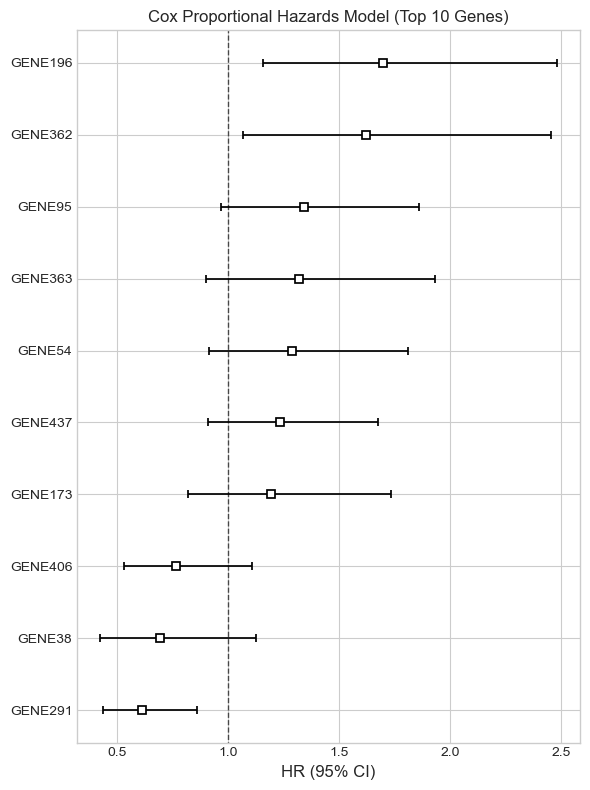

In [13]:
# =======================================================
# Multivariable Cox model with top genes (publication-ready)
# =======================================================
from lifelines import CoxPHFitter

# CoxPH requires a clean numeric dataframe
cox_df = expr_df[top_genes + ["time", "event"]].copy()
cox_df = cox_df.dropna()

# Fit Cox model
cph = CoxPHFitter()
cph.fit(cox_df, duration_col="time", event_col="event")

# Print summary
summary = cph.summary[["coef", "exp(coef)", "p", "exp(coef) lower 95%", "exp(coef) upper 95%"]]
summary.rename(columns={
    "coef": "log(HR)", 
    "exp(coef)": "HR", 
    "p": "p-value", 
    "exp(coef) lower 95%": "CI 2.5%",
    "exp(coef) upper 95%": "CI 97.5%"
}, inplace=True)

print("Multivariable Cox model results:\n")
display(summary)

# Save results
summary_path = os.path.join(RES_DIR, "cox_multivariable_results.csv")
summary.to_csv(summary_path)
print("Saved:", summary_path)

# Forest plot (HRs with CI)
plt.figure(figsize=(6, 8))
cph.plot(hazard_ratios=True)
plt.title("Cox Proportional Hazards Model (Top 10 Genes)")
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "cox_forest_plot.png"), dpi=600)
plt.show()


Top genes used for Cox: ['GENE291', 'GENE406', 'GENE95', 'GENE437', 'GENE38', 'GENE54', 'GENE362', 'GENE196', 'GENE363', 'GENE173']
CoxPH fitted on training set. Summary (first rows):


,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
GENE291,-0.837769,0.432675,0.246385,-1.320675,-0.354863,0.266955,0.701270,0.0,-3.400241,0.000673,10.536536
GENE406,-0.314226,0.730354,0.307225,-0.916376,0.287923,0.399966,1.333655,0.0,-1.022789,0.306407,1.706477
GENE95,0.233834,1.263434,0.243426,-0.243273,0.710940,0.784058,2.035904,0.0,0.960594,0.336756,1.570224
GENE437,0.463151,1.589073,0.219182,0.033561,0.892740,1.034130,2.441812,0.0,2.113083,0.034594,4.853347
GENE38,-0.605810,0.545632,0.339162,-1.270555,0.058935,0.280676,1.060706,0.0,-1.786197,0.074067,3.755019



Point estimates on test set:
RSF   C-index = 0.600
CoxPH C-index = 0.638

Bootstrap C-index (mean and 95% CI):
RSF:  mean=0.595, 95% CI=(0.362, 0.806)
Cox:  mean=0.628, 95% CI=(0.390, 0.853)

Saved performance CSV: results\model_performance_comparison.csv


,model,c_index,boot_mean,ci_low,ci_high
0,RandomSurvivalForest,0.600000,0.594749,0.361990,0.806427
1,CoxPH(top10),0.638095,0.628201,0.389654,0.852721


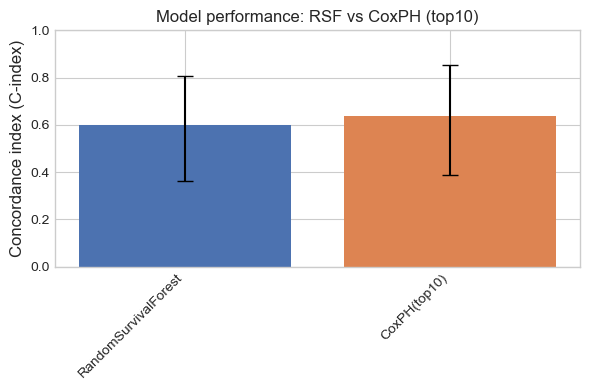

Saved plot: figures\model_cindex_comparison.png

Suggested text for manuscript (edit as needed):

We compared predictive discrimination between a Random Survival Forest (RSF) and a multivariable Cox proportional hazards model trained on the top 10 features selected by SHAP. On the held-out test set, the RSF achieved a concordance index of 0.600 (bootstrap mean 0.595, 95% CI 0.362-0.806), while the Cox model achieved 0.638 (bootstrap mean 0.628, 95% CI 0.390-0.853). These results indicate that [insert interpretation: e.g., RSF provides comparable/better discrimination and captures non-linear effects; CoxPH offers interpretable hazard ratios].


In [16]:
# ============================================================
# Fixed: Compare RSF vs CoxPH (C-index) with boolean event arrays
# ============================================================
import os, warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import CoxPHFitter
from sksurv.metrics import concordance_index_censored
from sklearn.utils import resample

# Output dirs
FIG_DIR = "figures"
RES_DIR = "results"
os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(RES_DIR, exist_ok=True)

# Sanity checks: required objects
required = ("best_rsf","X_train","X_test","y_train","y_test")
missing = [name for name in required if name not in globals()]
if missing:
    raise RuntimeError(f"Missing required objects in notebook: {missing}. Make sure you ran modeling cells (best_rsf, X_train/X_test, y_train/y_test).")

# Utility to get top_genes consistent with earlier ranking
if "top_shap" in globals():
    ranking = top_shap
elif os.path.exists(os.path.join(RES_DIR,"top_features_shap_surrogate.csv")):
    ranking = pd.read_csv(os.path.join(RES_DIR,"top_features_shap_surrogate.csv"), index_col=0).iloc[:,0]
elif os.path.exists(os.path.join(RES_DIR,"top_features_permutation.csv")):
    ranking = pd.read_csv(os.path.join(RES_DIR,"top_features_permutation.csv"), index_col=0).iloc[:,0]
else:
    ranking = pd.Series(1.0, index=X_train.columns)

ranking = ranking[ranking.index.isin(X_train.columns)]
top_genes = ranking.head(10).index.tolist()
print("Top genes used for Cox:", top_genes)

# -------------------------
# Helper: Build cox-style dataframe given X (pandas) and y structured array
# -------------------------
def build_cox_df(X_df, y_struct):
    cdf = X_df.copy().reset_index(drop=True)
    # y_struct is a structured numpy array with fields ('event','time') or similar
    # Convert to numpy arrays and attach
    cdf["time"]  = np.asarray(y_struct["time"])
    # convert event to boolean (True = event happened)
    cdf["event"] = np.asarray(y_struct["event"]).astype(bool)
    return cdf

# Build train/test frames for Cox
cox_train = build_cox_df(X_train[top_genes], y_train)
cox_test  = build_cox_df(X_test[top_genes],  y_test)

# -------------------------
# Fit Cox on training set
# -------------------------
cph = CoxPHFitter()
cph.fit(cox_train, duration_col="time", event_col="event", show_progress=False)
print("CoxPH fitted on training set. Summary (first rows):")
display(cph.summary.head())

# -------------------------
# Predict risk scores for test set
# -------------------------
# RSF risk: many RSF implementations return higher -> greater risk; keep as-is
rsf_risk_test = best_rsf.predict(X_test)  # numpy array or Series

# Cox risk: partial hazard (higher -> greater risk)
cox_risk_test = cph.predict_partial_hazard(cox_test)
# ensure numpy array for concordance function
if hasattr(cox_risk_test, "values"):
    cox_risk_vals = cox_risk_test.values
else:
    cox_risk_vals = np.asarray(cox_risk_test)

# -------------------------
# Compute point C-index (convert events to boolean)
# -------------------------
event_bool = np.asarray(y_test["event"]).astype(bool)
time_vals  = np.asarray(y_test["time"]).astype(float)

# RSF C-index
cindex_rsf = concordance_index_censored(event_bool, time_vals, np.asarray(rsf_risk_test))[0]
# Cox C-index (use cox_test event/time aligned with cox_risk_vals)
cindex_cox = concordance_index_censored(np.asarray(cox_test["event"]).astype(bool),
                                        np.asarray(cox_test["time"]).astype(float),
                                        cox_risk_vals)[0]

print(f"\nPoint estimates on test set:")
print(f"RSF   C-index = {cindex_rsf:.3f}")
print(f"CoxPH C-index = {cindex_cox:.3f}")

# -------------------------
# Bootstrap CI for both (test set)
# -------------------------
n_boot = 500   # 500 is usually enough; change to 1000 if you want longer run
rng = np.random.RandomState(42)
n_test = X_test.shape[0]

ci_rsf_boot = []
ci_cox_boot = []

for i in range(n_boot):
    # sample indices with replacement
    idx = rng.randint(0, n_test, n_test)
    # sample structured y_test
    y_bs = y_test[idx]
    # sample X_test (pandas) by iloc
    Xbs = X_test.iloc[idx].reset_index(drop=True)

    # RSF prediction on bootstrap sample
    pred_rsf_bs = best_rsf.predict(Xbs)
    # concordance expects boolean event & float time
    ev_bs = np.asarray(y_bs["event"]).astype(bool)
    t_bs  = np.asarray(y_bs["time"]).astype(float)
    try:
        ci_rsf_boot.append(concordance_index_censored(ev_bs, t_bs, np.asarray(pred_rsf_bs))[0])
    except Exception:
        ci_rsf_boot.append(np.nan)

    # Cox: build cox-compatible df for bootstrap sample (must include top_genes)
    cox_bs = build_cox_df(Xbs[top_genes].reset_index(drop=True), y_bs)
    pred_cox_bs = cph.predict_partial_hazard(cox_bs)
    try:
        pred_cox_vals = pred_cox_bs.values if hasattr(pred_cox_bs, "values") else np.asarray(pred_cox_bs)
        ci_cox_boot.append(concordance_index_censored(np.asarray(cox_bs["event"]).astype(bool),
                                                     np.asarray(cox_bs["time"]).astype(float),
                                                     pred_cox_vals)[0])
    except Exception:
        ci_cox_boot.append(np.nan)

# Summarize bootstrap arrays (drop nans)
def summarize_boot(bs_list):
    arr = np.array(bs_list, dtype=float)
    arr = arr[np.isfinite(arr)]
    if len(arr) == 0:
        return np.nan, np.nan, np.nan
    mean = np.mean(arr)
    low, high = np.percentile(arr, [2.5, 97.5])
    return mean, low, high

rsf_mean, rsf_low, rsf_high = summarize_boot(ci_rsf_boot)
cox_mean, cox_low, cox_high = summarize_boot(ci_cox_boot)

print("\nBootstrap C-index (mean and 95% CI):")
print(f"RSF:  mean={rsf_mean:.3f}, 95% CI=({rsf_low:.3f}, {rsf_high:.3f})")
print(f"Cox:  mean={cox_mean:.3f}, 95% CI=({cox_low:.3f}, {cox_high:.3f})")

# -------------------------
# Save summary & plot
# -------------------------
perf_df = pd.DataFrame([
    {"model":"RandomSurvivalForest", "c_index":cindex_rsf, "boot_mean":rsf_mean, "ci_low":rsf_low, "ci_high":rsf_high},
    {"model":"CoxPH(top10)",           "c_index":cindex_cox, "boot_mean":cox_mean, "ci_low":cox_low, "ci_high":cox_high}
])
perf_csv = os.path.join(RES_DIR, "model_performance_comparison.csv")
perf_df.to_csv(perf_csv, index=False)
print("\nSaved performance CSV:", perf_csv)
display(perf_df)

# Bar plot with error bars (use bootstrap CI if available)
plt.figure(figsize=(6,4))
x = np.arange(len(perf_df))
errs = [[perf_df["c_index"] - perf_df["ci_low"]], [perf_df["ci_high"] - perf_df["c_index"]]]
# if CI nan, fallback to zeros
yerr = np.vstack([
    (perf_df["c_index"] - perf_df["ci_low"]).fillna(0).values,
    (perf_df["ci_high"] - perf_df["c_index"]).fillna(0).values
])
plt.bar(x, perf_df["c_index"], yerr=yerr, capsize=6, color=["#4C72B0","#DD8452"])
plt.xticks(x, perf_df["model"], rotation=45, ha="right")
plt.ylim(0,1)
plt.ylabel("Concordance index (C-index)")
plt.title("Model performance: RSF vs CoxPH (top10)")
plt.tight_layout()
plot_path = os.path.join(FIG_DIR, "model_cindex_comparison.png")
plt.savefig(plot_path, dpi=300, bbox_inches="tight")
plt.show()
print("Saved plot:", plot_path)

# Suggested manuscript text
print("\nSuggested text for manuscript (edit as needed):\n")
print(f"""We compared predictive discrimination between a Random Survival Forest (RSF) and a multivariable Cox proportional hazards model trained on the top 10 features selected by SHAP. On the held-out test set, the RSF achieved a concordance index of {cindex_rsf:.3f} (bootstrap mean {rsf_mean:.3f}, 95% CI {rsf_low:.3f}-{rsf_high:.3f}), while the Cox model achieved {cindex_cox:.3f} (bootstrap mean {cox_mean:.3f}, 95% CI {cox_low:.3f}-{cox_high:.3f}). These results indicate that [insert interpretation: e.g., RSF provides comparable/better discrimination and captures non-linear effects; CoxPH offers interpretable hazard ratios].""")


In [18]:
# Fixed KM plotting with proper legends
def plot_km_for_gene(df, gene, ax=None, title=None, cmap_high="#c92a2a", cmap_low="#2a6fc9"):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6,4))
    vals = pd.to_numeric(df[gene], errors="coerce")
    med = np.nanmedian(vals)
    sub = df.loc[vals.notna(), ["time","event"]].copy()
    sub["expr"] = vals[vals.notna()]
    sub["group"] = np.where(sub["expr"] >= med, "High", "Low")
    if sub["group"].nunique() < 2:
        ax.text(0.5, 0.5, f"Insufficient groups for {gene}", ha="center")
        ax.axis("off")
        return None

    A = sub[sub.group=="High"]
    B = sub[sub.group=="Low"]

    kmf_h = KaplanMeierFitter()
    kmf_h.fit(A.time, event_observed=A.event, label="High expression")
    kmf_l = KaplanMeierFitter()
    kmf_l.fit(B.time, event_observed=B.event, label="Low expression")

    kmf_h.plot_survival_function(ax=ax, ci_show=True, color=cmap_high, linewidth=2)
    kmf_l.plot_survival_function(ax=ax, ci_show=True, color=cmap_low, linewidth=2)

    # Log-rank test
    lr = logrank_test(A.time, B.time, event_observed_A=A.event, event_observed_B=B.event)
    pval = lr.p_value

    ax.set_title(f"{gene} (median split)\nLog-rank p={pval:.3g}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Survival probability")
    ax.set_ylim(-0.02, 1.02)
    ax.legend(frameon=False, loc="best")
    return (kmf_h, kmf_l, sub, pval)


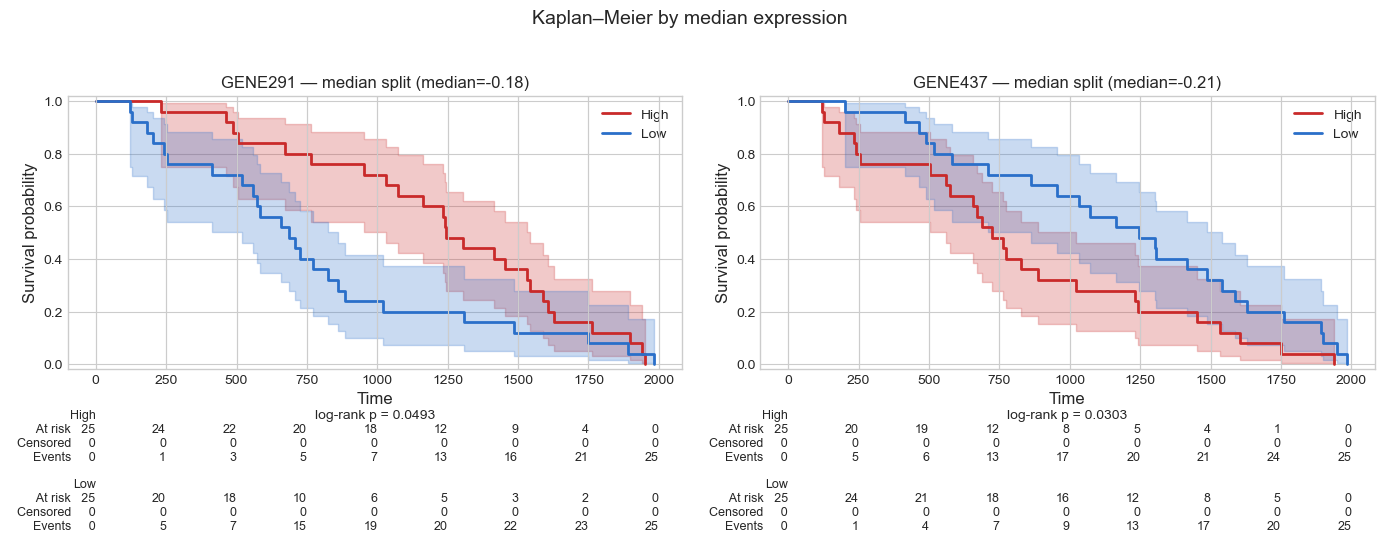

Saved KM figure: figures\km_GENE291_GENE437_pub.png


,gene,n_high,n_low,logrank_p
0,GENE291,25,25,0.049292
1,GENE437,25,25,0.030322


Saved summary CSV: results/km_two_genes_summary.csv


In [19]:
# -----------------------------
# Clean KM panels with p-value annotation under each panel (publication-ready)
# -----------------------------
import os, warnings
warnings.filterwarnings("ignore")
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from lifelines.plotting import add_at_risk_counts

FIG_DIR = "figures"
os.makedirs(FIG_DIR, exist_ok=True)

# --- check inputs / build combined_df if not present ---
if "combined_df" not in globals():
    # combine train + test (preserves how earlier code used combined)
    X_all = pd.concat([X_train, X_test], axis=0).reset_index(drop=True)
    y_all = np.concatenate([y_train, y_test], axis=0)
    combined_df = X_all.copy().reset_index(drop=True)
    combined_df["time"]  = np.asarray(y_all["time"], dtype=float)
    combined_df["event"] = np.asarray(y_all["event"]).astype(int)

# Genes to plot
g1, g2 = "GENE291", "GENE437"
for g in (g1, g2):
    if g not in combined_df.columns:
        raise RuntimeError(f"{g} not found in combined_df columns.")

# Helper to create groups and fit KMs
def prepare_km_data(df, gene):
    vals = pd.to_numeric(df[gene], errors="coerce")
    med = np.nanmedian(vals)
    mask = vals.notna()
    sub = df.loc[mask, ["time","event"]].copy()
    sub["expr"] = vals[mask].values
    sub["group"] = np.where(sub["expr"] >= med, "High", "Low")
    return sub, med

def plot_km_panel(ax, df_sub, gene, color_high="#c92a2a", color_low="#2a6fc9"):
    # split
    A = df_sub[df_sub.group=="High"]
    B = df_sub[df_sub.group=="Low"]
    # fit
    kmf_h = KaplanMeierFitter()
    kmf_l = KaplanMeierFitter()
    kmf_h.fit(A.time, event_observed=A.event, label="High")
    kmf_l.fit(B.time, event_observed=B.event, label="Low")
    # plot curves with CI
    kmf_h.plot_survival_function(ax=ax, ci_show=True, color=color_high, linewidth=2)
    kmf_l.plot_survival_function(ax=ax, ci_show=True, color=color_low, linewidth=2)
    # cosmetics
    ax.set_xlabel("Time")
    ax.set_ylabel("Survival probability")
    ax.set_ylim(-0.02, 1.02)
    ax.legend(frameon=False, loc="best")
    # logrank test (p)
    lr = logrank_test(A.time, B.time, event_observed_A=A.event, event_observed_B=B.event)
    pval = lr.p_value
    # annotate p-value below the axis (publication style)
    ax.text(0.5, -0.18, f"log-rank p = {pval:.3g}", transform=ax.transAxes,
            ha="center", fontsize=10)
    # return objects for at-risk and counts
    return kmf_h, kmf_l, A, B, pval

# Build subs
sub1, med1 = prepare_km_data(combined_df, g1)
sub2, med2 = prepare_km_data(combined_df, g2)

# Create figure with space for at-risk tables
fig, axes = plt.subplots(1,2, figsize=(14,6))

km1 = plot_km_panel(axes[0], sub1, g1)
km2 = plot_km_panel(axes[1], sub2, g2)

# Add at-risk tables under each axis if supported
try:
    add_at_risk_counts(km1[0], km1[1], ax=axes[0], fontsize=9)
    add_at_risk_counts(km2[0], km2[1], ax=axes[1], fontsize=9)
except Exception:
    # fallback: simple text counts
    for ax, (kmh, kml, A, B, p) in zip(axes, (km1, km2)):
        ax.text(0.02, -0.25, f"n High = {A.shape[0]}    n Low = {B.shape[0]}", transform=ax.transAxes, fontsize=9)

# Titles with median value for clarity (optional)
axes[0].set_title(f"{g1} — median split (median={med1:.2f})", fontsize=12)
axes[1].set_title(f"{g2} — median split (median={med2:.2f})", fontsize=12)

plt.suptitle("Kaplan–Meier by median expression", fontsize=14)
plt.tight_layout(rect=[0,0.02,1,0.95])

# Save high-res for publication
out_path = os.path.join(FIG_DIR, "km_GENE291_GENE437_pub.png")
plt.savefig(out_path, dpi=600, bbox_inches="tight")
plt.show()

print("Saved KM figure:", out_path)
# Print small summary table
summary = []
for gene, sub, km in zip((g1,g2),(sub1,sub2),(km1,km2)):
    A = sub[sub.group=="High"]; B = sub[sub.group=="Low"]
    lr = logrank_test(A.time, B.time, event_observed_A=A.event, event_observed_B=B.event)
    summary.append({"gene":gene, "n_high":int(A.shape[0]), "n_low":int(B.shape[0]), "logrank_p":float(lr.p_value)})
summary_df = pd.DataFrame(summary)
display(summary_df)
summary_df.to_csv(os.path.join("results", "km_two_genes_summary.csv"), index=False)
print("Saved summary CSV: results/km_two_genes_summary.csv")


Using top_genes: ['GENE291', 'GENE406', 'GENE95', 'GENE437', 'GENE38', 'GENE54', 'GENE362', 'GENE196', 'GENE363', 'GENE173']


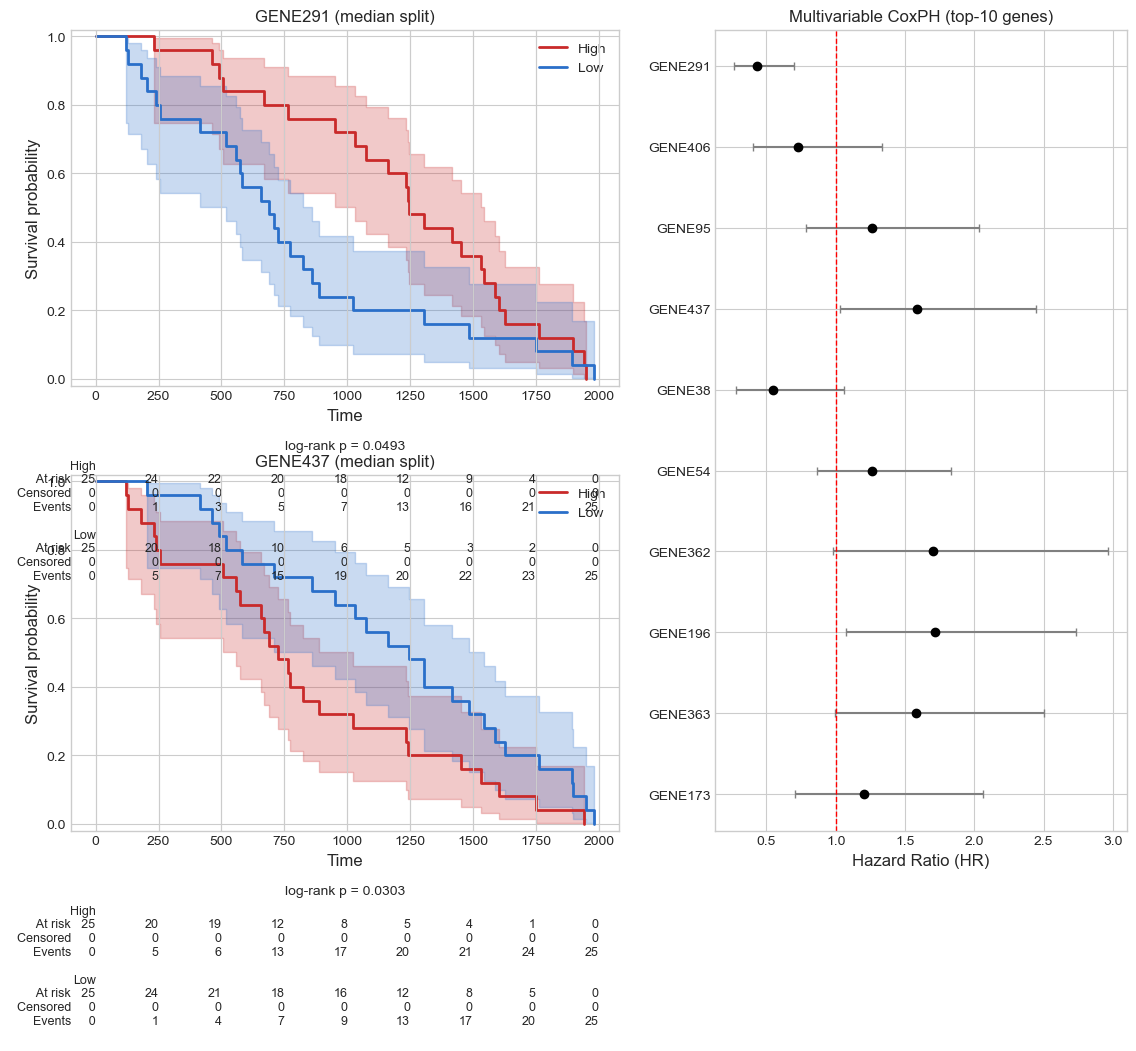

Saved multipanel figure: figures\panel_km_cox_top10.png
Saved Cox CSV: results\cox_top10_readable.csv
Saved KM summary CSV: results\km_two_genes_summary.csv


In [20]:
# ---------------------------
# FINAL: Multipanel figure (KM for two genes + Cox forest top10) — copy-paste and run once
# ---------------------------
import os, warnings
warnings.filterwarnings("ignore")
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from matplotlib import gridspec
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test
from lifelines.plotting import add_at_risk_counts

# OUTPUT
FIG_DIR = "figures"
RES_DIR = "results"
os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(RES_DIR, exist_ok=True)

# --- Sanity checks: required objects from earlier modeling must exist ---
required = ("X_train","X_test","y_train","y_test")
missing = [r for r in required if r not in globals()]
if missing:
    raise RuntimeError(f"Missing required notebook objects: {missing}. Run the modeling cells that create X_train, X_test, y_train, y_test first.")

# top_genes fallback logic if not present
if "top_genes" not in globals():
    candidates = []
    for f in ("results/top_features_permutation.csv", "results/top_features_shap_surrogate.csv", "results/top_features_permutation.csv"):
        if os.path.exists(f):
            df = pd.read_csv(f, index_col=0)
            candidates = df.index.tolist()
            break
    if candidates:
        top_genes = candidates[:10]
    else:
        top_genes = list(X_train.columns[:10])
print("Using top_genes:", top_genes)

# Genes to produce KM panels for (customize if you want)
g_top = "GENE291"
g_bot = "GENE437"
for g in (g_top, g_bot):
    if g not in X_train.columns and g not in X_test.columns:
        raise RuntimeError(f"Required gene '{g}' not found in feature columns. Edit variables or run preprocessing.")

# Build combined dataframe (train+test) for KM plotting (keeps more events)
X_all = pd.concat([X_train, X_test], axis=0).reset_index(drop=True)
y_all = np.concatenate([y_train, y_test], axis=0)
combined_df = X_all.copy().reset_index(drop=True)
combined_df["time"]  = np.asarray(y_all["time"], dtype=float)
combined_df["event"] = np.asarray(y_all["event"]).astype(int)

# Helper to prepare KM sub-dataframe (median split)
def prepare_sub(df, gene):
    vals = pd.to_numeric(df[gene], errors="coerce")
    med = np.nanmedian(vals)
    mask = vals.notna()
    sub = df.loc[mask, ["time","event"]].copy()
    sub["expr"] = vals[mask].values
    sub["group"] = np.where(sub["expr"] >= med, "High", "Low")
    return sub, med

# Prepare subs
sub_top, med_top = prepare_sub(combined_df, g_top)
sub_bot, med_bot = prepare_sub(combined_df, g_bot)

# Function to draw KM on an axis and annotate p-value and at-risk
def draw_km_axis(ax, sub, gene, cmap_high="#c92a2a", cmap_low="#2a6fc9"):
    A = sub[sub.group=="High"]
    B = sub[sub.group=="Low"]
    if len(A)==0 or len(B)==0:
        ax.text(0.5, 0.5, f"Insufficient groups for {gene}", ha="center"); ax.axis("off"); return None
    kmf_h = KaplanMeierFitter(); kmf_h.fit(A.time, event_observed=A.event, label="High")
    kmf_l = KaplanMeierFitter(); kmf_l.fit(B.time, event_observed=B.event, label="Low")
    kmf_h.plot_survival_function(ax=ax, ci_show=True, linewidth=2, color=cmap_high)
    kmf_l.plot_survival_function(ax=ax, ci_show=True, linewidth=2, color=cmap_low)
    lr = logrank_test(A.time, B.time, event_observed_A=A.event, event_observed_B=B.event)
    pval = lr.p_value
    ax.set_ylim(-0.02, 1.02)
    ax.set_xlabel("Time")
    ax.set_ylabel("Survival probability")
    ax.set_title(f"{gene} (median split)")
    # p-value below axis
    ax.text(0.5, -0.18, f"log-rank p = {pval:.3g}", transform=ax.transAxes, ha="center", fontsize=10)
    ax.legend(frameon=False, loc="best")
    return (kmf_h, kmf_l, A, B, pval)

# Build Cox dataframe from training set for multivariable CoxPH
cox_train = X_train[top_genes].copy().reset_index(drop=True)
cox_train["time"] = np.asarray(y_train["time"], dtype=float)
cox_train["event"] = np.asarray(y_train["event"]).astype(int)

# Fit CoxPH
cph = CoxPHFitter()
cph.fit(cox_train, duration_col="time", event_col="event", show_progress=False)
cox_summary = cph.summary.reset_index()
cox_readable = cox_summary[["covariate","exp(coef)","exp(coef) lower 95%","exp(coef) upper 95%","p"]]
cox_readable.columns = ["gene","HR","CI_low","CI_high","p_value"]
cox_readable.to_csv(os.path.join(RES_DIR,"cox_top10_readable.csv"), index=False)

# --- Create multipanel figure ---
fig = plt.figure(figsize=(12,9), constrained_layout=False)
spec = gridspec.GridSpec(ncols=2, nrows=2, figure=fig, width_ratios=[1.0, 0.75], height_ratios=[1,1], hspace=0.25)

ax_km1 = fig.add_subplot(spec[0,0])
ax_km2 = fig.add_subplot(spec[1,0])
ax_forest = fig.add_subplot(spec[:,1])  # spans two rows

# Draw KM panels
km_top_res = draw_km_axis(ax_km1, sub_top, g_top)
km_bot_res = draw_km_axis(ax_km2, sub_bot, g_bot)

# Add at-risk tables under KM axes (lifelines helper)
try:
    if km_top_res is not None:
        add_at_risk_counts(km_top_res[0], km_top_res[1], ax=ax_km1, fontsize=9)
    if km_bot_res is not None:
        add_at_risk_counts(km_bot_res[0], km_bot_res[1], ax=ax_km2, fontsize=9)
except Exception:
    # fallback small text count
    for ax, res in zip((ax_km1, ax_km2),(km_top_res, km_bot_res)):
        if res is None: continue
        A = res[2]; B=res[3]
        ax.text(0.02, -0.25, f"n High={A.shape[0]}  n Low={B.shape[0]}", transform=ax.transAxes, fontsize=9)

# Build forest plot on ax_forest
# We'll plot HR (exp(coef)) with 95% CI
genes = cox_readable["gene"].values[::-1]  # reverse for nicer plotting
hrs   = cox_readable["HR"].values[::-1]
cil   = cox_readable["CI_low"].values[::-1]
cih   = cox_readable["CI_high"].values[::-1]
y_pos = np.arange(len(genes))

ax_forest.errorbar(hrs, y_pos, xerr=[hrs-cil, cih-hrs], fmt='o', color='black', ecolor='gray', capsize=3)
ax_forest.axvline(1.0, color='red', linestyle='--', linewidth=1)
ax_forest.set_yticks(y_pos)
ax_forest.set_yticklabels(genes)
ax_forest.set_xlabel("Hazard Ratio (HR)")
ax_forest.set_title("Multivariable CoxPH (top-10 genes)")

# Adjust layout, emphasize readability
plt.subplots_adjust(left=0.08, right=0.96, top=0.95, bottom=0.06, hspace=0.35)
out_path = os.path.join(FIG_DIR, "panel_km_cox_top10.png")
plt.savefig(out_path, dpi=600, bbox_inches="tight")
plt.show()

# Save results
cox_readable.to_csv(os.path.join(RES_DIR,"cox_top10_readable.csv"), index=False)
km_summary = [
    {"gene":g_top, "n_high":int(km_top_res[2].shape[0]), "n_low":int(km_top_res[3].shape[0]), "logrank_p":float(km_top_res[4])},
    {"gene":g_bot, "n_high":int(km_bot_res[2].shape[0]), "n_low":int(km_bot_res[3].shape[0]), "logrank_p":float(km_bot_res[4])},
]
pd.DataFrame(km_summary).to_csv(os.path.join(RES_DIR,"km_two_genes_summary.csv"), index=False)

print("Saved multipanel figure:", out_path)
print("Saved Cox CSV:", os.path.join(RES_DIR,"cox_top10_readable.csv"))
print("Saved KM summary CSV:", os.path.join(RES_DIR,"km_two_genes_summary.csv"))
